# what's the neuron yield across probes, experimenters and recording sites?
Anne Urai & Nate Miska, 2020

In [34]:
# GENERAL THINGS FOR COMPUTING AND PLOTTING
import pandas as pd
import numpy as np
import os, sys, time
import scipy as sp

# visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# ibl specific things
import datajoint as dj
from ibl_pipeline import reference, subject, action, acquisition, data, behavior
ephys = dj.create_virtual_module('ephys', 'ibl_ephys')
figpath = os.path.join(os.path.expanduser('~'), 'Data/Figures_IBL')

## 1. neuron yield per lab and Npix probe over time
Replicates https://github.com/int-brain-lab/analysis/blob/master/python/probe_performance_over_sessions.py using DJ

In [35]:
probe_insertions = ephys.ProbeInsertion * ephys.DefaultCluster.Metrics * subject.SubjectLab
probe_insertions = probe_insertions.proj('probe_serial_number', 'probe_model_name', 'lab_name', 'metrics',
                                         session_date='DATE(session_start_time)')
clusts = probe_insertions.fetch(format='frame').reset_index()

In [36]:
# put metrics into df columns from the blob
for kix, k in enumerate(['ks2_label']):
    tmp_var = []
    for id, c in clusts.iterrows():
        if k in c['metrics'].keys():
            tmp = c['metrics'][k]
        else:
            tmp = np.nan
        tmp_var.append(tmp)
    clusts[k] = tmp_var
    
clusts

,subject_uuid,session_start_time,probe_idx,cluster_id,probe_model_name,probe_serial_number,metrics,lab_name,session_date,ks2_label
0,221b68e7-0014-46ae-b8af-308665d8b478,2020-01-29 16:19:34,0,0,3A,513180850,"{'presence_ratio': 0.9839743589743588, 'presen...",churchlandlab,2020-01-29,mua
1,221b68e7-0014-46ae-b8af-308665d8b478,2020-01-29 16:19:34,0,1,3A,513180850,"{'presence_ratio': 0.8173076923076923, 'presen...",churchlandlab,2020-01-29,mua
2,221b68e7-0014-46ae-b8af-308665d8b478,2020-01-29 16:19:34,0,2,3A,513180850,"{'presence_ratio': 0.875, 'presence_ratio_std'...",churchlandlab,2020-01-29,mua
3,221b68e7-0014-46ae-b8af-308665d8b478,2020-01-29 16:19:34,0,3,3A,513180850,"{'presence_ratio': 1.0, 'presence_ratio_std': ...",churchlandlab,2020-01-29,mua
4,221b68e7-0014-46ae-b8af-308665d8b478,2020-01-29 16:19:34,0,4,3A,513180850,"{'presence_ratio': 0.9935897435897436, 'presen...",churchlandlab,2020-01-29,mua
...,...,...,...,...,...,...,...,...,...,...
95331,b55c97f2-1024-4b16-9774-2d9049942f98,2020-01-31 14:36:40,1,385,3B2,18194824312,"{'presence_ratio': 0.389344262295082, 'presenc...",mainenlab,2020-01-31,mua
95332,b55c97f2-1024-4b16-9774-2d9049942f98,2020-01-31 14:36:40,1,386,3B2,18194824312,"{'presence_ratio': 0.6147540983606558, 'presen...",mainenlab,2020-01-31,good
95333,b55c97f2-1024-4b16-9774-2d9049942f98,2020-01-31 14:36:40,1,387,3B2,18194824312,"{'presence_ratio': 0.5409836065573771, 'presen...",mainenlab,2020-01-31,mua
95334,b55c97f2-1024-4b16-9774-2d9049942f98,2020-01-31 14:36:40,1,388,3B2,18194824312,"{'presence_ratio': 0.9959016393442623, 'presen...",mainenlab,2020-01-31,good


In [37]:
clusts['probe_name'] = clusts['lab_name'] + ', ' + clusts['probe_model_name'] + ': ' + clusts['probe_serial_number']
clusts_summ = clusts.groupby(['probe_name', 'session_start_time', 'ks2_label'])['session_date'].count().reset_index()

# use recording session number instead of date
clusts_summ['recording'] = clusts_summ.groupby(['probe_name']).cumcount() + 1
clusts_summ

,probe_name,session_start_time,ks2_label,session_date,recording
0,"angelakilab, 3B2: 18005102352",2020-01-24 14:22:03,good,175,1
1,"angelakilab, 3B2: 18005102352",2020-01-24 14:22:03,mua,500,2
2,"angelakilab, 3B2: 18005102352",2020-02-18 14:25:54,good,31,3
3,"angelakilab, 3B2: 18005102352",2020-02-18 14:25:54,mua,62,4
4,"angelakilab, 3B2: 18005108752",2020-01-20 16:55:52,good,174,1
...,...,...,...,...,...
511,"zadorlab, 3B2: 18194822771",2020-03-21 14:17:23,mua,185,8
512,"zadorlab, 3B2: 18194822771",2020-03-22 12:56:40,good,123,9
513,"zadorlab, 3B2: 18194822771",2020-03-22 12:56:40,mua,244,10
514,"zadorlab, 3B2: 18194822771",2020-03-23 12:58:00,good,295,11


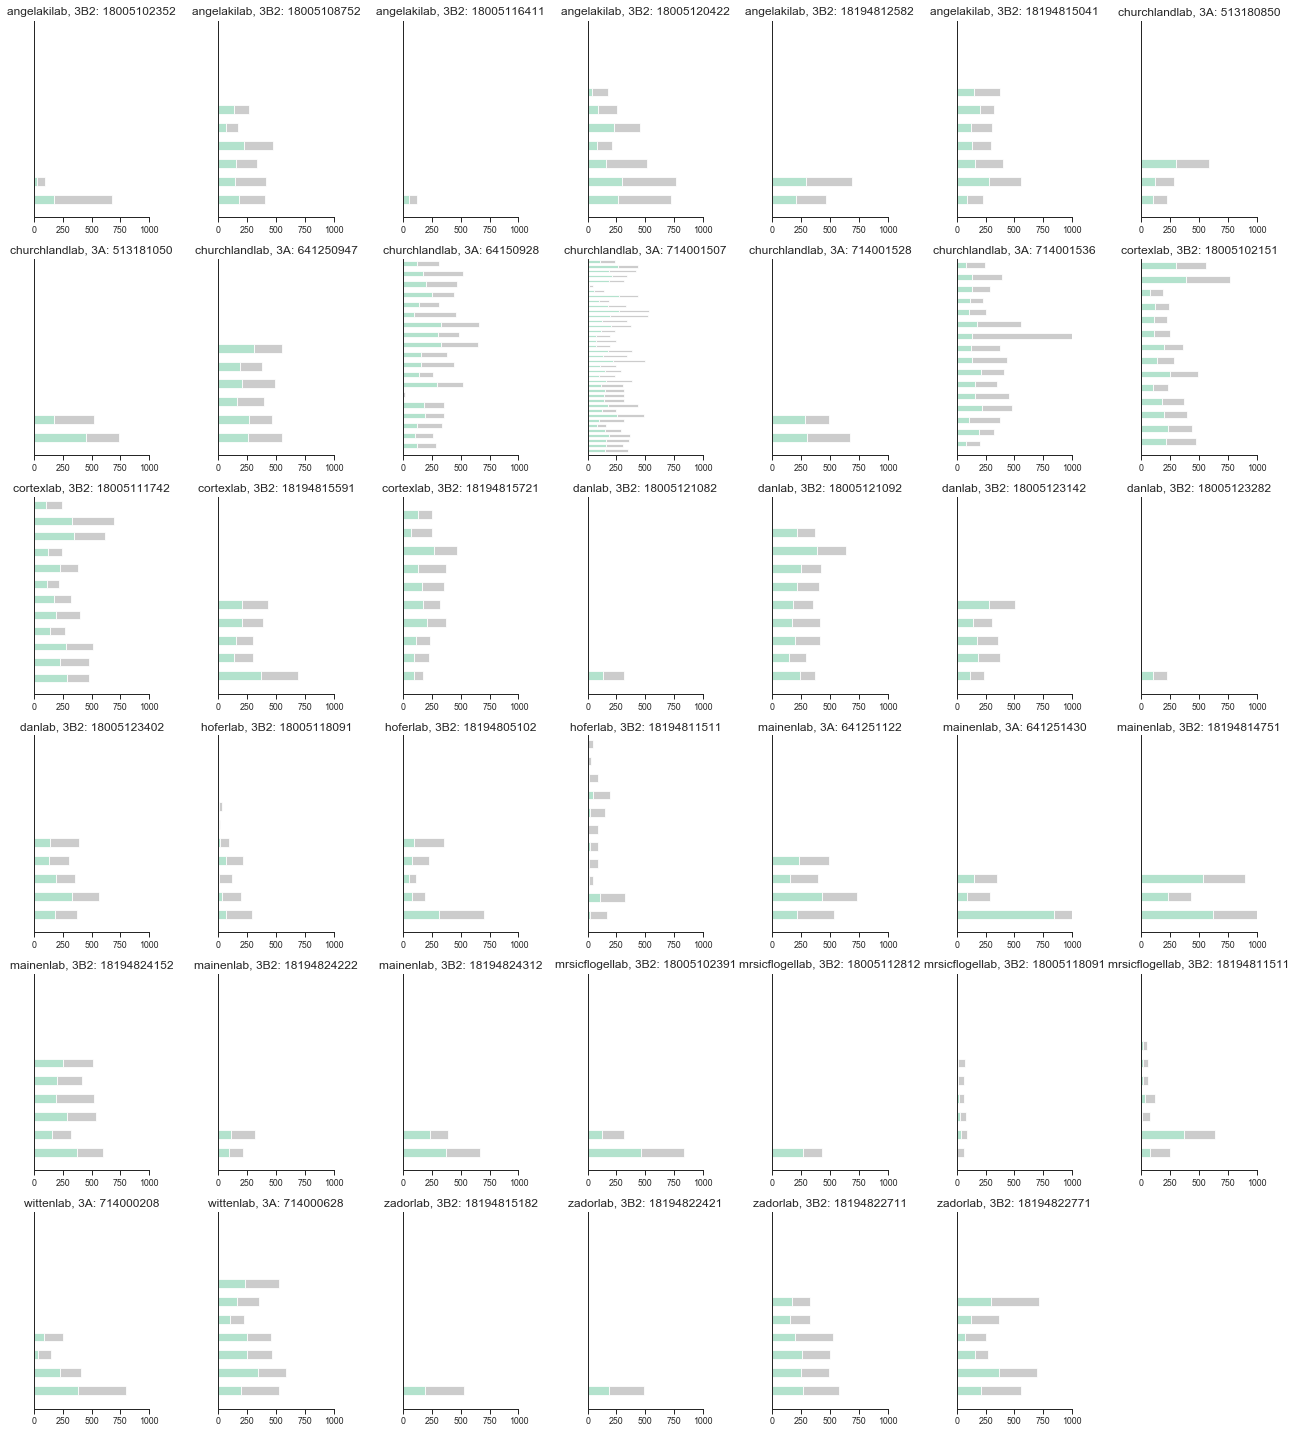

In [38]:
sns.set(style="ticks", context="paper")
g, axes = plt.subplots(6,7,figsize=(18,20))

for probe, ax in zip(clusts_summ.probe_name.unique(), axes.flatten()):
    df = clusts_summ[clusts_summ.probe_name==probe].groupby(['session_start_time','ks2_label']).session_date.sum()
    df.unstack().plot.barh(ax=ax, stacked=True, legend=False, colormap='Pastel2')
    ax.set_title(probe, fontsize=12)
    ax.set_yticks([])
    ax.set_ylabel('')
    ax.set_ylim([-1, np.max([max(ax.get_ylim()), 10])])
    ax.set_xlim([0, 1000])
    
axes.flatten()[-1].set_axis_off()
sns.despine(trim=True)   
plt.tight_layout()
plt.xlabel('Number of KS2 neurons')
plt.ylabel('Recording session')
g.savefig(os.path.join(figpath, 'probe_yield_oversessions.pdf'))

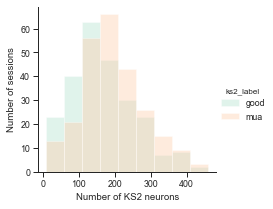

In [49]:
## overall distribution of neurons per session
g = sns.FacetGrid(data=clusts_summ, hue='ks2_label', palette='Pastel2')
g.map(sns.distplot, "session_date", bins=np.arange(10, 500, 50), hist=True, rug=False, kde=False).add_legend()
g.set_xlabels('Number of KS2 neurons')
g.set_ylabels('Number of sessions')
g.savefig(os.path.join(figpath, 'probe_yield_allrecs.pdf'))

## 2. how does probe yield in the repeated site differ between mice/experimenters?

In [50]:
probes_rs = (ephys.ProbeTrajectory & 'insertion_data_source = "Planned"'
             & 'x BETWEEN -2400 AND -2100' & 'y BETWEEN -2100 AND -1900' & 'theta BETWEEN 14 AND 16')

clust = ephys.DefaultCluster * ephys.DefaultCluster.Metrics * probes_rs * subject.SubjectLab() * subject.Subject()
clust = clust.proj('cluster_amp', 'cluster_depth', 'firing_rate', 'subject_nickname', 'lab_name','metrics',
                   'x', 'y', 'theta', 'phi', 'depth')
clusts = clust.fetch(format='frame').reset_index()
clusts['col_name'] = clusts['lab_name'] + ', ' + clusts['subject_nickname']

# put metrics into df columns from the blob
for kix, k in enumerate(clusts['metrics'][0].keys()):
    tmp_var = []
    for id, c in clusts.iterrows():
        if k in c['metrics'].keys():
            tmp = c['metrics'][k]
        else:
            tmp = np.nan
        tmp_var.append(tmp)
    clusts[k] = tmp_var

clusts

,subject_uuid,session_start_time,probe_idx,cluster_id,insertion_data_source,cluster_amp,cluster_depth,firing_rate,metrics,x,...,subject_nickname,col_name,presence_ratio,presence_ratio_std,amplitude_cutoff,amplitude_std,epoch_name,ks2_label,isi_viol,ks2_contamination_pct
0,15f98ab5-20d8-4345-a5de-21912a39575f,2020-01-20 14:56:51,0,0,Planned,0.000029,20.0,3.803890,"{'presence_ratio': 0.99645390070922, 'presence...",-2243.0,...,CSHL047,"churchlandlab, CSHL047",0.996454,63.686513,0.500000,1.573217,0,mua,0.465936,100.0
1,15f98ab5-20d8-4345-a5de-21912a39575f,2020-01-20 14:56:51,0,1,Planned,0.000032,20.0,1.879770,"{'presence_ratio': 0.9858156028368794, 'presen...",-2243.0,...,CSHL047,"churchlandlab, CSHL047",0.985816,23.260556,0.500000,3.989448,0,mua,4.930500,100.0
2,15f98ab5-20d8-4345-a5de-21912a39575f,2020-01-20 14:56:51,0,2,Planned,0.000032,20.0,2.184850,"{'presence_ratio': 0.9858156028368794, 'presen...",-2243.0,...,CSHL047,"churchlandlab, CSHL047",0.985816,24.302066,0.500000,3.188369,0,mua,1.581179,100.0
3,15f98ab5-20d8-4345-a5de-21912a39575f,2020-01-20 14:56:51,0,3,Planned,0.000041,60.0,7.224170,"{'presence_ratio': 0.99645390070922, 'presence...",-2243.0,...,CSHL047,"churchlandlab, CSHL047",0.996454,28.182733,0.001922,3.898700,0,good,0.002558,0.6
4,15f98ab5-20d8-4345-a5de-21912a39575f,2020-01-20 14:56:51,0,4,Planned,0.000034,20.0,2.211200,"{'presence_ratio': 0.9858156028368794, 'presen...",-2243.0,...,CSHL047,"churchlandlab, CSHL047",0.985816,32.216894,0.365339,4.141652,0,mua,5.625625,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3380,ed8918e4-6a37-4b3d-9b4d-daa14eca0c70,2020-03-06 15:52:04,0,393,Planned,0.000047,1800.0,0.073946,"{'presence_ratio': 0.5727848101265823, 'presen...",-2243.0,...,CSHL059,"churchlandlab, CSHL059",0.572785,2.091875,0.000555,2.826250,0,good,0.000000,0.0
3381,ed8918e4-6a37-4b3d-9b4d-daa14eca0c70,2020-03-06 15:52:04,0,394,Planned,0.000038,2960.0,1.681870,"{'presence_ratio': 0.9651898734177216, 'presen...",-2243.0,...,CSHL059,"churchlandlab, CSHL059",0.965190,29.788095,0.010582,3.078341,0,good,0.252311,9.1
3382,ed8918e4-6a37-4b3d-9b4d-daa14eca0c70,2020-03-06 15:52:04,0,395,Planned,0.000038,3160.0,3.037810,"{'presence_ratio': 0.9240506329113924, 'presen...",-2243.0,...,CSHL059,"churchlandlab, CSHL059",0.924051,36.089326,0.028005,2.839225,0,mua,0.335138,100.0
3383,ed8918e4-6a37-4b3d-9b4d-daa14eca0c70,2020-03-06 15:52:04,0,396,Planned,0.000057,3120.0,2.314700,"{'presence_ratio': 0.9841772151898734, 'presen...",-2243.0,...,CSHL059,"churchlandlab, CSHL059",0.984177,54.519035,0.006001,4.103955,0,good,0.022202,0.0


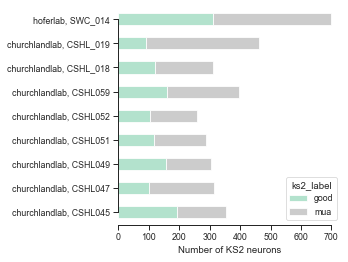

In [57]:
sns.set(style="ticks", context="paper")
g, axes = plt.subplots(1,1,figsize=(4,4))
df = clusts.groupby(['col_name', 'ks2_label']).ks2_label.count()
df.unstack().plot.barh(ax=axes, stacked=True, legend=True, colormap='Pastel2')
axes.set_ylabel('')
sns.despine(trim=True)   
plt.xlabel('Number of KS2 neurons')
g.savefig(os.path.join(figpath, 'probe_yield_rs.pdf'))

plotting


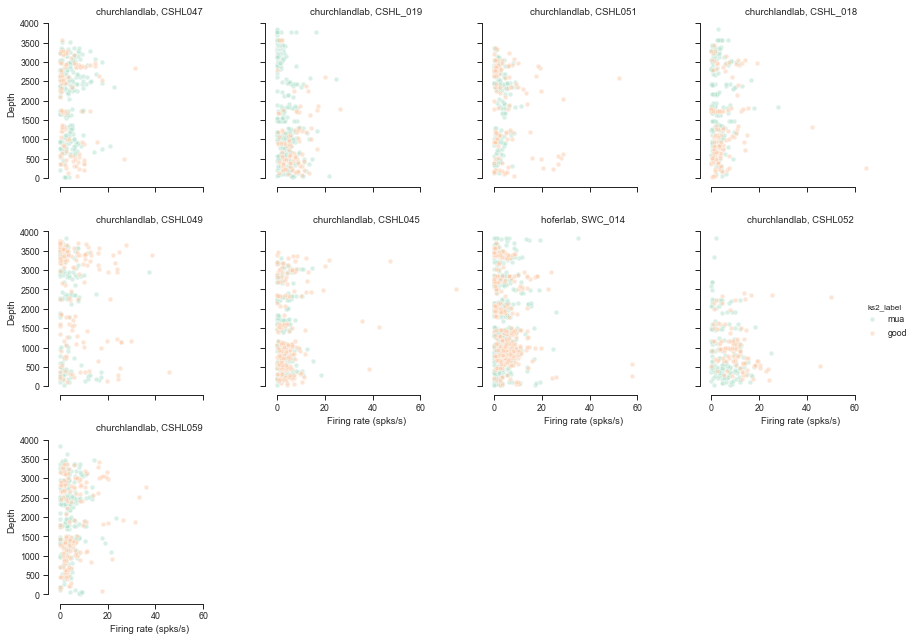

In [58]:
## firing rate as a function of depth
print('plotting')
g = sns.FacetGrid(data=clusts, col='col_name', col_wrap=4, hue='ks2_label',
                  palette='Pastel2')
g.map(sns.scatterplot, "firing_rate", "cluster_depth", alpha=0.5).add_legend()
g.set_titles('{col_name}')
g.set_xlabels('Firing rate (spks/s)')
g.set_ylabels('Depth')
plt.tight_layout()
sns.despine(trim=True)
g.savefig(os.path.join(figpath, 'neurons_rsi_firingrate.pdf'))
